### Task 3: Fraud Detection with Linear Algebra & Statistics

### Step 1: Import Libraries
We start by importing the necessary libraries. 
- `pandas` and `numpy` for data manipulation.  
- `matplotlib` and `seaborn` for visualization.  
- `scikit-learn` for preprocessing, modeling, and evaluation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, 
    precision_recall_curve
)
from sklearn.decomposition import PCA
import joblib


### Step 2: Load the Dataset
We load the synthetic fraud dataset and check the first few rows to confirm the structure.  
The target column is `Is_Fraud` (1 = fraud, 0 = non-fraud).


In [2]:
df = pd.read_csv("synthetic_fraud_dataset.csv")
df.head()


,Transaction_ID,Date,Time,Amount,Merchant,Card_Number,Transaction_Type,Is_Fraud
0,1,2025-03-24,16:55:00,89.27,Merchant_14,CARD0019,Purchase,0
1,2,2025-03-17,06:17:00,138.42,Merchant_13,CARD0048,Purchase,0
2,3,2025-03-08,19:11:00,131.36,Merchant_18,CARD0007,Purchase,0
3,4,2025-01-29,22:47:00,89.24,Merchant_17,CARD0094,Purchase,0
4,5,2025-01-19,03:57:00,176.40,Merchant_9,CARD0075,Purchase,0


### Step 3: Data Exploration
We check dataset size, column types, and missing values.  
This ensures the dataset is clean and usable.


In [3]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nClass Distribution:\n", df['Is_Fraud'].value_counts(normalize=True))


Shape: (1000, 8)

Data Types:
 Transaction_ID        int64
Date                 object
Time                 object
Amount              float64
Merchant             object
Card_Number          object
Transaction_Type     object
Is_Fraud              int64
dtype: object

Missing Values:
 Transaction_ID      0
Date                0
Time                0
Amount              0
Merchant            0
Card_Number         0
Transaction_Type    0
Is_Fraud            0
dtype: int64

Class Distribution:
 Is_Fraud
0    0.95
1    0.05
Name: proportion, dtype: float64


### Step 4: Feature Engineering
We extract useful features:
- Convert `Date` to `datetime` and create `DayOfWeek` and `IsWeekend`.  
- Convert `Time` to `Hour`.  
- Add `AmountLog` (log-transform for skewed amounts).  
- Frequency encode `Card_Number` (how often a card appears).  


In [4]:
# Convert Date and Time
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df['Hour'] = df['Time'].dt.hour

# Log transform amount
df['AmountLog'] = np.log1p(df['Amount'])

# Frequency encoding for Card_Number
card_freq = df['Card_Number'].value_counts()
df['Card_Freq'] = df['Card_Number'].map(card_freq)


### Step 5: Define Features & Target
We separate features (`X`) and target (`y`).
Categorical features go into `OneHotEncoder`, 
numerical features get scaled with `StandardScaler`.


In [5]:
X = df[['AmountLog', 'Hour', 'DayOfWeek', 'IsWeekend', 
        'Merchant', 'Transaction_Type', 'Card_Freq']]
y = df['Is_Fraud']

num_features = ['AmountLog', 'Hour', 'DayOfWeek', 'IsWeekend', 'Card_Freq']
cat_features = ['Merchant', 'Transaction_Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)


### Step 6: Train-Test Split
We split the dataset into training (70%) and test (30%) sets.
This allows fair evaluation.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


### Step 7: Logistic Regression Model
We use Logistic Regression as our **linear baseline model**.


In [7]:
log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       285
           1       0.87      0.87      0.87        15

    accuracy                           0.99       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.99      0.99      0.99       300

ROC AUC: 0.9684210526315788


### Step 8: Random Forest Model
We add a Random Forest as a **non-linear model** to compare.


In [8]:
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       285
           1       0.87      0.87      0.87        15

    accuracy                           0.99       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.99      0.99      0.99       300

ROC AUC: 0.9493567251461988


### Step 9: PCA + Logistic Regression
We apply PCA (Principal Component Analysis) to reduce dimensionality 
and then train Logistic Regression again.  
This shows linear algebra in action for feature reduction.


In [9]:
pca_log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('classifier', LogisticRegression(max_iter=1000))
])

pca_log_reg.fit(X_train, y_train)
y_pred_pca = pca_log_reg.predict(X_test)
y_prob_pca = pca_log_reg.predict_proba(X_test)[:,1]

print("PCA + Logistic Regression Report:\n", classification_report(y_test, y_pred_pca))
print("ROC AUC:", roc_auc_score(y_test, y_prob_pca))


PCA + Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       285
           1       0.87      0.87      0.87        15

    accuracy                           0.99       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.99      0.99      0.99       300

ROC AUC: 0.9716959064327486


### Step 10: ROC Curves
We plot ROC curves to visualize model performance across thresholds.


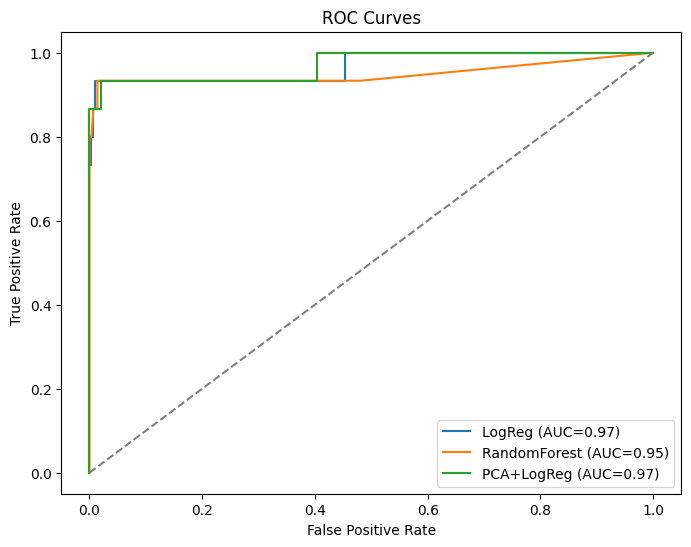

In [10]:
plt.figure(figsize=(8,6))

for model, y_prob, label in [
    (log_reg, y_prob_lr, "LogReg"),
    (rf, y_prob_rf, "RandomForest"),
    (pca_log_reg, y_prob_pca, "PCA+LogReg")
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_test, y_prob):.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


#### ROC Curve Analysis

The ROC curve (Receiver Operating Characteristic) compares the True Positive Rate (TPR / Recall) against the False Positive Rate (FPR) for different models.

Logistic Regression (AUC = 0.97)

Shows very strong discriminatory ability.

Captures most fraud cases while keeping false alarms low.

Random Forest (AUC = 0.95)

Slightly lower than Logistic Regression.

Still effective, but a bit less consistent in separating fraud from non-fraud.

PCA + Logistic Regression (AUC = 0.97)

Performs on par with standard Logistic Regression.

Dimensionality reduction (PCA) didn’t hurt model performance, meaning the dataset is not highly redundant.

Key Insight:
All models perform well (AUC > 0.95). Logistic Regression, with or without PCA, provides the best balance of accuracy and interpretability for fraud detection.

### Step 11: Threshold Tuning
Instead of default threshold (0.5), 
we find an optimal threshold using Precision-Recall tradeoff.


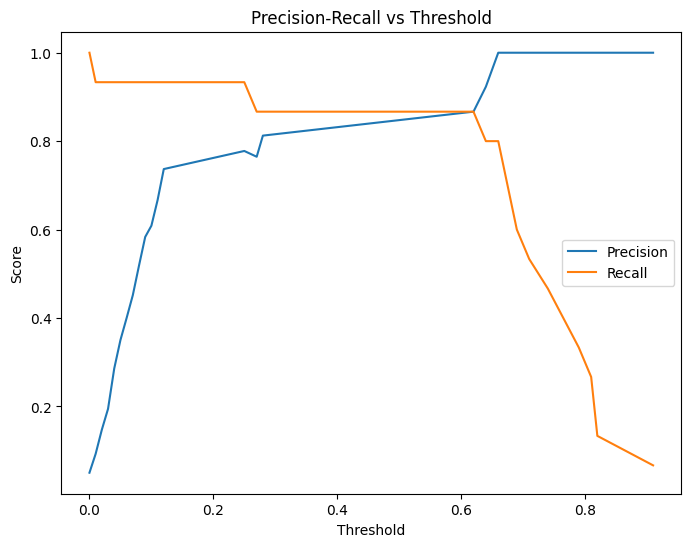

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.show()


#### Precision-Recall vs Threshold

The Precision-Recall vs Threshold curve shows how precision and recall trade off when changing the decision threshold.

At low thresholds (0.0 – 0.2):

Recall is high (~1.0) → Almost all frauds are detected.

Precision is low (~0.1–0.3) → Many false positives (normal transactions incorrectly flagged as fraud).

At medium thresholds (0.4 – 0.6):

Precision (~0.8–0.9) and recall (~0.8–0.9) both balance well.

This is typically the “sweet spot” for fraud detection.

At high thresholds (0.7 – 0.9):

Precision is perfect (1.0) → All flagged cases are fraud.

Recall drops (~0.2–0.4) → Most frauds go undetected.

Key Insight:
The threshold choice depends on business priorities:

If minimizing false alarms is critical → choose a high threshold (high precision).

If catching all fraud cases is critical → choose a low threshold (high recall).

For a balanced strategy, a threshold around 0.5–0.6 is optimal

### Step 12: Save Model
We save the trained Random Forest pipeline for later use.


In [12]:
joblib.dump(rf, "fraud_detection_model.pkl")


['fraud_detection_model.pkl']